# IGN DATA ANALYSIS and PREDICTIVE MODELLING

In [0]:
from google.colab import files
uploaded = files.upload()

Saving ign.csv to ign.csv


In [0]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
# Import libraries

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Put this when it's called
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

In [0]:
df=pd.read_csv('ign.csv', engine='python')
df=df[df.columns[1:]]
df=df.drop('url',axis=1)
df=df.drop_duplicates()
#replace target variable Y and N to 1 and 0
df.editors_choice=df.editors_choice.replace('Y',1)
df.editors_choice=df.editors_choice.replace('N',0)
df.head()

,score_phrase,title,platform,score,genre,editors_choice,release_year,release_month,release_day
0,Amazing,LittleBigPlanet PS Vita,PlayStation Vita,9.0,Platformer,1,2012,9,12
1,Amazing,LittleBigPlanet PS Vita -- Marvel Super Hero E...,PlayStation Vita,9.0,Platformer,1,2012,9,12
2,Great,Splice: Tree of Life,iPad,8.5,Puzzle,0,2012,9,12
3,Great,NHL 13,Xbox 360,8.5,Sports,0,2012,9,11
4,Great,NHL 13,PlayStation 3,8.5,Sports,0,2012,9,11


In [0]:
df["genre"].fillna("Unknown", inplace = True) 

In [0]:
df.describe()

,score,editors_choice,release_year,release_month,release_day
count,18577.000000,18577.000000,18577.000000,18577.000000,18577.000000
mean,6.950799,0.188889,2006.524627,7.136944,15.595683
std,1.711676,0.391431,4.581089,3.476183,8.689712
min,0.500000,0.000000,1970.000000,1.000000,1.000000
25%,6.000000,0.000000,2003.000000,4.000000,8.000000
50%,7.300000,0.000000,2007.000000,8.000000,15.000000
75%,8.200000,0.000000,2010.000000,10.000000,23.000000
max,10.000000,1.000000,2016.000000,12.000000,31.000000


In [0]:
def draw_missing_data_table(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data
draw_missing_data_table(df)

,Total,Percent
release_day,0,0.0
release_month,0,0.0
release_year,0,0.0
editors_choice,0,0.0
genre,0,0.0
score,0,0.0
platform,0,0.0
title,0,0.0
score_phrase,0,0.0


In [0]:
print(df.isnull().sum())

score_phrase      0
title             0
platform          0
score             0
genre             0
editors_choice    0
release_year      0
release_month     0
release_day       0
dtype: int64


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18577 entries, 0 to 18624
Data columns (total 9 columns):
score_phrase      18577 non-null object
title             18577 non-null object
platform          18577 non-null object
score             18577 non-null float64
genre             18577 non-null object
editors_choice    18577 non-null int64
release_year      18577 non-null int64
release_month     18577 non-null int64
release_day       18577 non-null int64
dtypes: float64(1), int64(4), object(4)
memory usage: 1.4+ MB


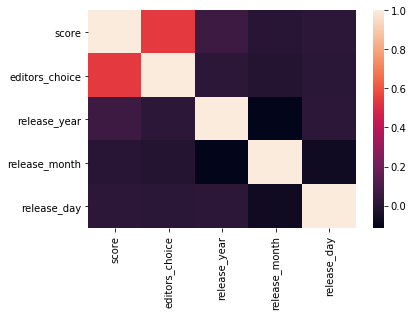

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
corr = df.corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

In [0]:
from sklearn import preprocessing
from collections import defaultdict
d = defaultdict(preprocessing.LabelEncoder)

# Encoding the categorical variable
fit = df.select_dtypes(include=['object']).fillna('NA').apply(lambda x: d[x.name].fit_transform(x))

#Convert the categorical columns based on encoding
for i in list(d.keys()):
    df[i] = d[i].transform(df[i].fillna('NA'))

In [0]:
features = df[df.columns.difference(['editors_choice'])]
labels = df['editors_choice']

In [0]:
features = features.fillna(0)

WOE and IV

In [0]:
# import packages
import pandas as pd
import numpy as np
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import re
import traceback
import string

max_bin = 20
force_bin = 3

# define a binning function
def mono_bin(Y, X, n = max_bin):
    
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv)

In [0]:
final_iv, IV = data_vars(df[df.columns.difference(['editors_choice'])],df.editors_choice)

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [0]:
final_iv

,VAR_NAME,MIN_VALUE,MAX_VALUE,COUNT,EVENT,EVENT_RATE,NONEVENT,NON_EVENT_RATE,DIST_EVENT,DIST_NON_EVENT,WOE,IV
0,genre,0.0,13.0,6198,983,0.158600,5215,0.841400,0.280137,0.346098,-0.211443,0.020350
1,genre,14.0,80.0,6237,1263,0.202501,4974,0.797499,0.359932,0.330104,0.086508,0.020350
2,genre,81.0,112.0,6142,1263,0.205633,4879,0.794367,0.359932,0.323799,0.105792,0.020350
3,platform,0.0,29.0,7414,1265,0.170623,6149,0.829377,0.360502,0.408083,-0.123975,0.012560
4,platform,30.0,35.0,5039,951,0.188728,4088,0.811272,0.271017,0.271303,-0.001055,0.012560
5,platform,36.0,58.0,6124,1293,0.211137,4831,0.788863,0.368481,0.320613,0.139154,0.012560
6,release_day,1.0,15.0,9292,1726,0.185751,7566,0.814249,0.491878,0.502124,-0.020616,0.000420
7,release_day,16.0,31.0,9285,1783,0.192030,7502,0.807970,0.508122,0.497876,0.020370,0.000420
8,release_month,1.0,8.0,10425,1930,0.185132,8495,0.814868,0.550014,0.563778,-0.024716,0.000768
9,release_month,9.0,12.0,8152,1579,0.193695,6573,0.806305,0.449986,0.436222,0.031064,0.000768


In [0]:
IV = IV.rename(columns={'VAR_NAME':'index'})
IV.sort_values(['IV'],ascending=0)

,index,IV
5,score,2.836895
6,score_phrase,1.226215
0,genre,0.020350
1,platform,0.012560
7,title,0.003305
3,release_month,0.000768
2,release_day,0.000420
4,release_year,0.000021


Apply WOE values to your dataframe columns¶
The below code snippet can be used to apply the WOE values to your dataframe columns.

In [0]:
transform_vars_list = df.columns.difference(['editors_choice'])
transform_prefix = 'new_' # leave this value blank if you need replace the original column values

In [0]:
transform_vars_list

Index(['genre', 'platform', 'release_day', 'release_month', 'release_year',
       'score', 'score_phrase', 'title'],
      dtype='object')

In [0]:
for var in transform_vars_list:
    small_df = final_iv[final_iv['VAR_NAME'] == var]
    transform_dict = dict(zip(small_df.MAX_VALUE,small_df.WOE))
    replace_cmd = ''
    replace_cmd1 = ''
    for i in sorted(transform_dict.items()):
        replace_cmd = replace_cmd + str(i[1]) + str(' if x <= ') + str(i[0]) + ' else '
        replace_cmd1 = replace_cmd1 + str(i[1]) + str(' if x == "') + str(i[0]) + '" else '
    replace_cmd = replace_cmd + '0'
    replace_cmd1 = replace_cmd1 + '0'
    if replace_cmd != '0':
        try:
            df[transform_prefix + var] = df[var].apply(lambda x: eval(replace_cmd))
        except:
            df[transform_prefix + var] = df[var].apply(lambda x: eval(replace_cmd1))

In [0]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()

clf.fit(features,labels)

preds = clf.predict(features)

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(preds,labels)
print(accuracy)

1.0


In [0]:
from pandas import DataFrame
VI = DataFrame(clf.feature_importances_, columns = ["RF"], index=features.columns)

In [0]:
VI = VI.reset_index()
VI.sort_values(['RF'],ascending=0)

,index,RF
5,score,0.573752
6,score_phrase,0.183730
4,release_year,0.062925
7,title,0.047687
1,platform,0.041174
2,release_day,0.034913
0,genre,0.028857
3,release_month,0.026962


Recursive Feature Elimination

In [0]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
rfe = RFE(model, 20)
fit = rfe.fit(features, labels)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [0]:
from pandas import DataFrame
Selected = DataFrame(rfe.support_, columns = ["RFE"], index=features.columns)
Selected = Selected.reset_index()

In [0]:
Selected[Selected['RFE'] == True]

,index,RFE
0,genre,True
1,platform,True
2,release_day,True
3,release_month,True
4,release_year,True
5,score,True
6,score_phrase,True
7,title,True


Variable Importance using Extratrees Classifier

1.   



In [0]:
from sklearn.ensemble import ExtraTreesClassifier

model = ExtraTreesClassifier()
model.fit(features, labels)

print(model.feature_importances_)

[0.0392466  0.04545486 0.04458897 0.03544346 0.06223042 0.41398011
 0.30838737 0.0506682 ]


In [0]:
from pandas import DataFrame
FI = DataFrame(model.feature_importances_, columns = ["Extratrees"], index=features.columns)

In [0]:
FI = FI.reset_index()

In [0]:
FI.sort_values(['Extratrees'],ascending=0)

,index,Extratrees
5,score,0.413980
6,score_phrase,0.308387
4,release_year,0.062230
7,title,0.050668
1,platform,0.045455
2,release_day,0.044589
0,genre,0.039247
3,release_month,0.035443


Chi Square

In [0]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

model = SelectKBest(score_func=chi2, k=5)
fit = model.fit(features.abs(), labels)

In [0]:
from pandas import DataFrame
pd.options.display.float_format = '{:.2f}'.format
chi_sq = DataFrame(fit.scores_, columns = ["Chi_Square"], index=features.columns)

In [0]:
chi_sq = chi_sq.reset_index()

In [0]:
chi_sq.sort_values('Chi_Square',ascending=0)

,index,Chi_Square
7,title,15180.18
6,score_phrase,3977.54
5,score,2289.62
0,genre,2039.58
1,platform,256.37
2,release_day,6.42
3,release_month,1.53
4,release_year,0.07


L1 feature selection




In [0]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(features, labels)
model = SelectFromModel(lsvc,prefit=True)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [0]:
from pandas import DataFrame
l1 = DataFrame(model.get_support(), columns = ["L1"], index=features.columns)
l1 = l1.reset_index()

In [0]:
l1[l1['L1'] == True]

,index,L1
0,genre,True
1,platform,True
2,release_day,True
3,release_month,True
4,release_year,True
5,score,True
6,score_phrase,True


Combine all together

In [0]:
from functools import reduce
dfs = [IV, VI, Selected, FI, chi_sq, l1]
final_results = reduce(lambda left,right: pd.merge(left,right,on='index'), dfs)

In [0]:
columns = ['IV', 'RF', 'Extratrees', 'Chi_Square']

score_table = pd.DataFrame({},[])
score_table['index'] = final_results['index']

for i in columns:
    score_table[i] = final_results['index'].isin(list(final_results.nlargest(5,i)['index'])).astype(int)
    
score_table['RFE'] = final_results['RFE'].astype(int)
score_table['L1'] = final_results['L1'].astype(int)

In [0]:
score_table['final_score'] = score_table.sum(axis=1)

In [0]:
score_table.sort_values('final_score',ascending=0)

,index,IV,RF,Extratrees,Chi_Square,RFE,L1,final_score
1,platform,1,1,1,1,1,1,6
5,score,1,1,1,1,1,1,6
6,score_phrase,1,1,1,1,1,1,6
7,title,1,1,1,1,1,0,5
0,genre,1,0,0,1,1,1,4
4,release_year,0,1,1,0,1,1,4
2,release_day,0,0,0,0,1,1,2
3,release_month,0,0,0,0,1,1,2


Multicollinearity

In [0]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [0]:
def calculate_vif(features):
    vif = pd.DataFrame()
    vif["Features"] = features.columns
    vif["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]    
    return(vif)

In [0]:
features = features[list(score_table[score_table['final_score'] >= 2]['index'])]

In [0]:
vif = calculate_vif(features)
while vif['VIF'][vif['VIF'] > 10].any():
    remove = vif.sort_values('VIF',ascending=0)['Features'][:1]
    features.drop(remove,axis=1,inplace=True)
    vif = calculate_vif(features)

In [0]:
list(vif['Features'])

['genre', 'platform', 'release_day', 'release_month', 'score_phrase', 'title']

Descriptive Stats and Visualization - For selected variables

In [0]:
final_vars = list(vif['Features']) + ['editors_choice']

In [0]:
df1 = df[final_vars].fillna(0)

In [0]:
df1.describe()

,genre,platform,release_day,release_month,score_phrase,title,editors_choice
count,18577.00,18577.00,18577.00,18577.00,18577.00,18577.00,18577.00
mean,52.46,34.61,15.60,7.14,4.69,6364.62,0.19
std,39.41,13.75,8.69,3.48,2.45,3622.78,0.39
min,0.00,0.00,1.00,1.00,0.00,0.00,0.00
25%,4.00,29.00,8.00,4.00,4.00,3237.00,0.00
50%,68.00,31.00,15.00,8.00,5.00,6356.00,0.00
75%,86.00,47.00,23.00,10.00,7.00,9564.00,0.00
max,112.00,58.00,31.00,12.00,10.00,12588.00,1.00


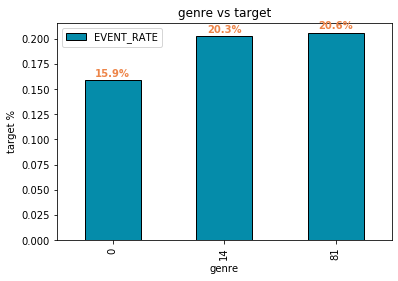

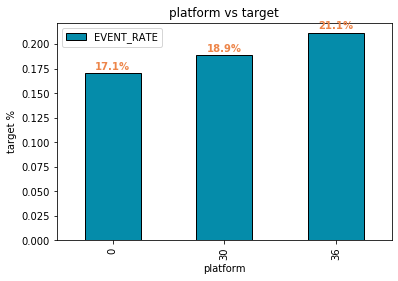

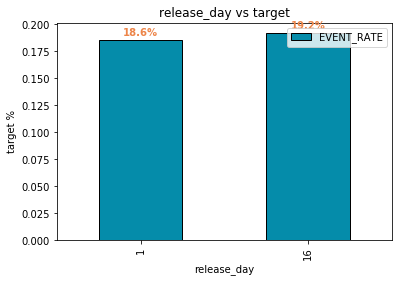

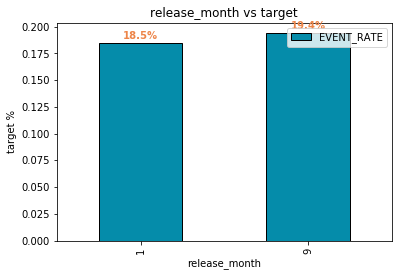

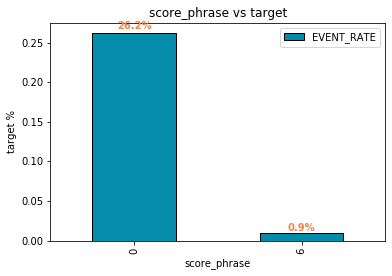

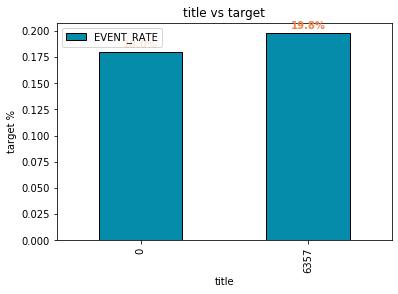

In [0]:
bar_color = '#058caa'
num_color = '#ed8549'

final_iv,_ = data_vars(df1,df1['editors_choice'])
final_iv = final_iv[(final_iv.VAR_NAME != 'editors_choice')]
grouped = final_iv.groupby(['VAR_NAME'])
for key, group in grouped:
    ax = group.plot('MIN_VALUE','EVENT_RATE',kind='bar',color=bar_color,linewidth=1.0,edgecolor=['black'])
    ax.set_title(str(key) + " vs " + str('target'))
    ax.set_xlabel(key)
    ax.set_ylabel(str('target') + " %")
    rects = ax.patches
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.01*height, str(round(height*100,1)) + '%', 
                ha='center', va='bottom', color=num_color, fontweight='bold')

Model

In [0]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df1, test_size = 0.4)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

features_train = train[list(vif['Features'])]
label_train = train['editors_choice']
features_test = test[list(vif['Features'])]
label_test = test['editors_choice']

Random Forest

In [0]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()

clf.fit(features_train,label_train)

pred_train = clf.predict(features_train)
pred_test = clf.predict(features_test)

from sklearn.metrics import accuracy_score
accuracy_train = accuracy_score(pred_train,label_train)
accuracy_test = accuracy_score(pred_test,label_test)

from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(np.array(label_train), clf.predict_proba(features_train)[:,1])
auc_train = metrics.auc(fpr,tpr)

fpr, tpr, _ = metrics.roc_curve(np.array(label_test), clf.predict_proba(features_test)[:,1])
auc_test = metrics.auc(fpr,tpr)

print(accuracy_train,accuracy_test,auc_train,auc_test)

1.0 0.9037814560624411 1.0 0.9592012623074747


In [0]:
pd.crosstab(label_train,pd.Series(pred_train),rownames=['ACTUAL'],colnames=['PRED'])

PRED,0,1
ACTUAL,,
0,9080,0
1,0,2066


In [0]:
pd.crosstab(label_test,pd.Series(pred_test),rownames=['ACTUAL'],colnames=['PRED'])

PRED,0,1
ACTUAL,,
0,5799,189
1,526,917



Logistic Regression

In [0]:
clf = LogisticRegression()

clf.fit(features_train,label_train)

pred_train = clf.predict(features_train)
pred_test = clf.predict(features_test)

from sklearn.metrics import accuracy_score
accuracy_train = accuracy_score(pred_train,label_train)
accuracy_test = accuracy_score(pred_test,label_test)

from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(np.array(label_train), clf.predict_proba(features_train)[:,1])
auc_train = metrics.auc(fpr,tpr)

fpr, tpr, _ = metrics.roc_curve(np.array(label_test), clf.predict_proba(features_test)[:,1])
auc_test = metrics.auc(fpr,tpr)

print(accuracy_train,accuracy_test,auc_train,auc_test)

0.8849811591602369 0.8763288924774593 0.7348190335663203 0.7304676342752495


In [0]:
pd.crosstab(label_train,pd.Series(pred_train),rownames=['ACTUAL'],colnames=['PRED'])

PRED,0,1
ACTUAL,,
0,8887,193
1,1089,977


In [0]:

pd.crosstab(label_test,pd.Series(pred_test),rownames=['ACTUAL'],colnames=['PRED'])

PRED,0,1
ACTUAL,,
0,5838,150
1,769,674


Neural Network

In [0]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier()

clf.fit(features_train,label_train)

pred_train = clf.predict(features_train)
pred_test = clf.predict(features_test)

from sklearn.metrics import accuracy_score
accuracy_train = accuracy_score(pred_train,label_train)
accuracy_test = accuracy_score(pred_test,label_test)

from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(np.array(label_train), clf.predict_proba(features_train)[:,1])
auc_train = metrics.auc(fpr,tpr)

fpr, tpr, _ = metrics.roc_curve(np.array(label_test), clf.predict_proba(features_test)[:,1])
auc_test = metrics.auc(fpr,tpr)

print(accuracy_train,accuracy_test,auc_train,auc_test)

0.863179616005742 0.851971470865294 0.7536564303107582 0.7451148543332913


In [0]:
pd.crosstab(label_train,pd.Series(pred_train),rownames=['ACTUAL'],colnames=['PRED'])

PRED,0,1
ACTUAL,,
0,8857,223
1,1302,764


In [0]:
pd.crosstab(label_test,pd.Series(pred_test),rownames=['ACTUAL'],colnames=['PRED'])

PRED,0,1
ACTUAL,,
0,5809,179
1,921,522



Naive Bayes

In [0]:
from sklearn.naive_bayes import GaussianNB 
clf = GaussianNB()

clf.fit(features_train,label_train)

pred_train = clf.predict(features_train)
pred_test = clf.predict(features_test)

from sklearn.metrics import accuracy_score
accuracy_train = accuracy_score(pred_train,label_train)
accuracy_test = accuracy_score(pred_test,label_test)

from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(np.array(label_train), clf.predict_proba(features_train)[:,1])
auc_train = metrics.auc(fpr,tpr)

fpr, tpr, _ = metrics.roc_curve(np.array(label_test), clf.predict_proba(features_test)[:,1])
auc_test = metrics.auc(fpr,tpr)

print(accuracy_train,accuracy_test,auc_train,auc_test)

0.8816615826305401 0.8724263221639079 0.7414020154291636 0.7358499628038706


In [0]:
pd.crosstab(label_train,pd.Series(pred_train),rownames=['ACTUAL'],colnames=['PRED'])

PRED,0,1
ACTUAL,,
0,8832,248
1,1071,995


In [0]:
pd.crosstab(label_test,pd.Series(pred_test),rownames=['ACTUAL'],colnames=['PRED'])

PRED,0,1
ACTUAL,,
0,5796,192
1,756,687


Gradient Boosting

In [0]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier()

clf.fit(features_train,label_train)

pred_train = clf.predict(features_train)
pred_test = clf.predict(features_test)

from sklearn.metrics import accuracy_score
accuracy_train = accuracy_score(pred_train,label_train)
accuracy_test = accuracy_score(pred_test,label_test)

from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(np.array(label_train), clf.predict_proba(features_train)[:,1])
auc_train = metrics.auc(fpr,tpr)

fpr, tpr, _ = metrics.roc_curve(np.array(label_test), clf.predict_proba(features_test)[:,1])
auc_test = metrics.auc(fpr,tpr)

print(accuracy_train,accuracy_test,auc_train,auc_test)

0.9115377713978109 0.9059345983044005 0.9694822775714207 0.959131071105019


In [0]:
pd.crosstab(label_train,pd.Series(pred_train),rownames=['ACTUAL'],colnames=['PRED'])

PRED,0,1
ACTUAL,,
0,8986,94
1,892,1174


In [0]:
pd.crosstab(label_test,pd.Series(pred_test),rownames=['ACTUAL'],colnames=['PRED'])

PRED,0,1
ACTUAL,,
0,5924,64
1,635,808


Performance Tuning
Random Forest - Hyper parameter tuning

In [0]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

n_estimators = [int(x) for x in np.linspace(start = 10, stop = 500, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(3, 10, num = 1)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestClassifier()

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 2, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(features_train, label_train)

print(rf_random.best_params_)

Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   10.8s finished


{'n_estimators': 118, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': True}


In [0]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(**rf_random.best_params_)

clf.fit(features_train,label_train)

pred_train = clf.predict(features_train)
pred_test = clf.predict(features_test)

from sklearn.metrics import accuracy_score
accuracy_train = accuracy_score(pred_train,label_train)
accuracy_test = accuracy_score(pred_test,label_test)

from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(np.array(label_train), clf.predict_proba(features_train)[:,1])
auc_train = metrics.auc(fpr,tpr)

fpr, tpr, _ = metrics.roc_curve(np.array(label_test), clf.predict_proba(features_test)[:,1])
auc_test = metrics.auc(fpr,tpr)

print(accuracy_train,accuracy_test,auc_train,auc_test)

0.9679705724026557 0.9063383124747678 0.9969452452332925 0.9596775556194393


Gradient Boosting - Hyper parameter tuning

In [0]:
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

n_estimators = [int(x) for x in np.linspace(start = 10, stop = 500, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(3, 10, num = 1)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]

grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

gb = GradientBoostingClassifier()

gf_tune = GridSearchCV(estimator = gb, param_grid = grid, cv = 2, verbose=2, n_jobs = -1)
gf_tune.fit(features_train, label_train)

print(gf_tune.best_params_)

Fitting 2 folds for each of 360 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   39.0s
[Parallel(n_jobs=-1)]: Done 162 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 365 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 648 tasks      | elapsed: 14.6min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed: 17.8min finished


{'max_depth': 3, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 64}


In [0]:
print(gf_tune.best_params_)

{'max_depth': 3, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 64}


In [0]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(**gf_tune.best_params_)

clf.fit(features_train,label_train)

pred_train = clf.predict(features_train)
pred_test = clf.predict(features_test)

from sklearn.metrics import accuracy_score
accuracy_train = accuracy_score(pred_train,label_train)
accuracy_test = accuracy_score(pred_test,label_test)

from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(np.array(label_train), clf.predict_proba(features_train)[:,1])
auc_train = metrics.auc(fpr,tpr)

fpr, tpr, _ = metrics.roc_curve(np.array(label_test), clf.predict_proba(features_test)[:,1])
auc_test = metrics.auc(fpr,tpr)

print(accuracy_train,accuracy_test,auc_train,auc_test)

0.9096536874214965 0.9041851702328085 0.9640312954441749 0.9579964965736509


Final Model and Model Performance

In [0]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()

clf.fit(features_train,label_train)

pred_train = clf.predict(features_train)
pred_test = clf.predict(features_test)

from sklearn.metrics import accuracy_score
accuracy_train = accuracy_score(pred_train,label_train)
accuracy_test = accuracy_score(pred_test,label_test)

from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(np.array(label_train), clf.predict_proba(features_train)[:,1])
auc_train = metrics.auc(fpr,tpr)

fpr, tpr, _ = metrics.roc_curve(np.array(label_test), clf.predict_proba(features_test)[:,1])
auc_test = metrics.auc(fpr,tpr)

print(accuracy_train,accuracy_test,auc_train,auc_test)

0.8849811591602369 0.8763288924774593 0.7348190335663203 0.7304676342752495


In [0]:
pd.crosstab(label_train,pd.Series(pred_train),rownames=['ACTUAL'],colnames=['PRED'])

PRED,0,1
ACTUAL,,
0,8887,193
1,1089,977


In [0]:
pd.crosstab(label_test,pd.Series(pred_test),rownames=['ACTUAL'],colnames=['PRED'])

PRED,0,1
ACTUAL,,
0,5838,150
1,769,674


In [0]:
#from bokeh.charts import Histogram
from ipywidgets import interact
from bokeh.plotting import figure
from bokeh.io import push_notebook, show, output_notebook

output_notebook()

from sklearn import metrics
preds = clf.predict_proba(features_train)[:,1]

fpr, tpr, _ = metrics.roc_curve(np.array(label_train), preds)
auc = metrics.auc(fpr,tpr)

p = figure(title="ROC Curve - Train data")
r = p.line(fpr,tpr,color='#0077bc',legend_label = 'AUC = '+ str(round(auc,3)), line_width=2)
s = p.line([0,1],[0,1], color= '#d15555',line_dash='dotdash',line_width=2)
show(p)

In [0]:
#from bokeh.charts import Histogram
from ipywidgets import interact
from bokeh.plotting import figure
from bokeh.io import push_notebook, show, output_notebook
output_notebook()

from sklearn import metrics
preds = clf.predict_proba(features_test)[:,1]

fpr, tpr, _ = metrics.roc_curve(np.array(label_test), preds)
auc = metrics.auc(fpr,tpr)

p = figure(title="ROC Curve - Test data")
r = p.line(fpr,tpr,color='#0077bc',legend_label = 'AUC = '+ str(round(auc,3)), line_width=2)
s = p.line([0,1],[0,1], color= '#d15555',line_dash='dotdash',line_width=2)
show(p)

Decile Plots and KS statistic

In [0]:
from collections import OrderedDict
import pandas as pd
import sys
%matplotlib inline
    
def plot_pandas_style(styler):
    from IPython.core.display import HTML
    html = '\n'.join([line.lstrip() for line in styler.render().split('\n')])
    return HTML(html)

def highlight_max(s,color='yellow'):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.max()
    return ['background-color: {}'.format(color) if v else '' for v in is_max]

def decile_labels(agg1,label,color='skyblue'):
    agg_dummy = pd.DataFrame(OrderedDict((('TOTAL',0),('TARGET',0),('NONTARGET',0),('PCT_TAR',0),('CUM_TAR',0),('CUM_NONTAR',0),('DIST_TAR',0),('DIST_NONTAR',0),('SPREAD',0))),index=[0])
    agg1 = agg1.append(agg_dummy).sort_index()
    agg1.index.name = label
    agg1 = agg1.style.apply(highlight_max, color = 'yellow', subset=['SPREAD'])
    agg1.bar(subset=['TARGET'], color='{}'.format(color))
    agg1.bar(subset=['TOTAL'], color='{}'.format(color))
    agg1.bar(subset=['PCT_TAR'], color='{}'.format(color))
    return(agg1)

def deciling(data,decile_by,target,nontarget):
    inputs = list(decile_by)
    inputs.extend((target,nontarget))
    decile = data[inputs]
    grouped = decile.groupby(decile_by)
    agg1 = pd.DataFrame({},index=[])
    agg1['TOTAL'] = grouped.sum()[nontarget] + grouped.sum()[target]
    agg1['TARGET'] = grouped.sum()[target]
    agg1['NONTARGET'] = grouped.sum()[nontarget]
    agg1['PCT_TAR'] = grouped.mean()[target]*100
    agg1['CUM_TAR'] = grouped.sum()[target].cumsum()
    agg1['CUM_NONTAR'] = grouped.sum()[nontarget].cumsum()
    agg1['DIST_TAR'] = agg1['CUM_TAR']/agg1['TARGET'].sum()*100
    agg1['DIST_NONTAR'] = agg1['CUM_NONTAR']/agg1['NONTARGET'].sum()*100
    agg1['SPREAD'] = (agg1['DIST_TAR'] - agg1['DIST_NONTAR'])
    agg1 = decile_labels(agg1,'DECILE',color='skyblue')
    return(plot_pandas_style(agg1))

In [0]:
def scoring(features,clf,target):
    score = pd.DataFrame(clf.predict_proba(features)[:,1], columns = ['SCORE'])
    score['DECILE'] = pd.qcut(score['SCORE'].rank(method = 'first'),10,labels=range(10,0,-1))
    score['DECILE'] = score['DECILE'].astype(float)
    score['TARGET'] = target
    score['NONTARGET'] = 1 - target
    return(score)

In [0]:
scores_train = scoring(features_train,clf,label_train)
scores_test = scoring(features_test,clf,label_test)

In [0]:
deciling(scores_train,['DECILE'],'TARGET','NONTARGET')

,TOTAL,TARGET,NONTARGET,PCT_TAR,CUM_TAR,CUM_NONTAR,DIST_TAR,DIST_NONTAR,SPREAD
DECILE,,,,,,,,,
0.0,0,0,0,0,0,0,0,0,0
1.0,1115,955,160,85.6502,955,160,46.2246,1.76211,44.4625
2.0,1114,41,1073,3.68043,996,1233,48.2091,13.5793,34.6298
3.0,1115,2,1113,0.179372,998,2346,48.3059,25.837,22.4689
4.0,1114,99,1015,8.88689,1097,3361,53.0978,37.0154,16.0824
5.0,1115,252,863,22.6009,1349,4224,65.2953,46.5198,18.7754
6.0,1114,319,795,28.6355,1668,5019,80.7357,55.2753,25.4604
7.0,1115,346,769,31.0314,2014,5788,97.4831,63.7445,33.7386
8.0,1114,52,1062,4.66786,2066,6850,100,75.4405,24.5595


In [0]:
deciling(scores_test,['DECILE'],'TARGET','NONTARGET')

,TOTAL,TARGET,NONTARGET,PCT_TAR,CUM_TAR,CUM_NONTAR,DIST_TAR,DIST_NONTAR,SPREAD
DECILE,,,,,,,,,
0.0,0,0,0,0,0,0,0,0,0
1.0,743,636,107,85.5989,636,107,44.0748,1.78691,42.2879
2.0,743,51,692,6.86406,687,799,47.6091,13.3434,34.2658
3.0,743,0,743,0,687,1542,47.6091,25.7515,21.8576
4.0,743,65,678,8.74832,752,2220,52.1137,37.0741,15.0395
5.0,743,174,569,23.4186,926,2789,64.1719,46.5765,17.5954
6.0,743,238,505,32.0323,1164,3294,80.6653,55.01,25.6553
7.0,743,230,513,30.9556,1394,3807,96.6043,63.5772,33.0271
8.0,743,49,694,6.59489,1443,4501,100,75.167,24.833


Lift chart, Actual vs predicted and Gains chart

In [0]:
from collections import OrderedDict
import pandas as pd
import matplotlib.pyplot as plt

def plots(agg1,target,type):

    plt.figure(1,figsize=(20, 5))

    plt.subplot(131)
    plt.plot(agg1['DECILE'],agg1['ACTUAL'],label='Actual')
    plt.plot(agg1['DECILE'],agg1['PRED'],label='Pred')
    plt.xticks(range(10,110,10))
    plt.legend(fontsize=15)
    plt.grid(True)
    plt.title('Actual vs Predicted', fontsize=20)
    plt.xlabel("Population %",fontsize=15)
    plt.ylabel(str(target) + " " + str(type) + " %",fontsize=15)

    plt.subplot(132)
    X = agg1['DECILE'].tolist()
    X.append(0)
    Y = agg1['DIST_TAR'].tolist()
    Y.append(0)
    plt.plot(sorted(X),sorted(Y))
    plt.plot([0, 100], [0, 100],'r--')
    plt.xticks(range(0,110,10))
    plt.yticks(range(0,110,10))
    plt.grid(True)
    plt.title('Gains Chart', fontsize=20)
    plt.xlabel("Population %",fontsize=15)
    plt.ylabel(str(target) + str(" DISTRIBUTION") + " %",fontsize=15)
    plt.annotate(round(agg1[agg1['DECILE'] == 30].DIST_TAR.item(),2),xy=[30,30], 
            xytext=(25, agg1[agg1['DECILE'] == 30].DIST_TAR.item() + 5),fontsize = 13)
    plt.annotate(round(agg1[agg1['DECILE'] == 50].DIST_TAR.item(),2),xy=[50,50], 
            xytext=(45, agg1[agg1['DECILE'] == 50].DIST_TAR.item() + 5),fontsize = 13)

    plt.subplot(133)
    plt.plot(agg1['DECILE'],agg1['LIFT'])
    plt.xticks(range(10,110,10))
    plt.grid(True)
    plt.title('Lift Chart', fontsize=20)
    plt.xlabel("Population %",fontsize=15)
    plt.ylabel("Lift",fontsize=15)

    plt.tight_layout()

In [0]:
def gains(data,decile_by,target,score):
    inputs = list(decile_by)
    inputs.extend((target,score))
    decile = data[inputs]
    grouped = decile.groupby(decile_by)
    agg1 = pd.DataFrame({},index=[])
    agg1['ACTUAL'] = grouped.mean()[target]*100
    agg1['PRED'] = grouped.mean()[score]*100
    agg1['DIST_TAR'] = grouped.sum()[target].cumsum()/grouped.sum()[target].sum()*100
    agg1.index.name = 'DECILE'
    agg1 = agg1.reset_index()
    agg1['DECILE'] = agg1['DECILE']*10
    agg1['LIFT'] = agg1['DIST_TAR']/agg1['DECILE']
    plots(agg1,target,'Distribution')


In [0]:
lift_train = pd.concat([features_train,scores_train],axis=1)
lift_test = pd.concat([features_test,scores_test],axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: FutureWarning: `item` has been deprecated and will be removed in a future version
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: FutureWarning: `item` has been deprecated and will be removed in a future version
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: FutureWarning: `item` has been deprecated and will be removed in a future version
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: FutureWarning: `item` has been deprecated and will be removed in a future version


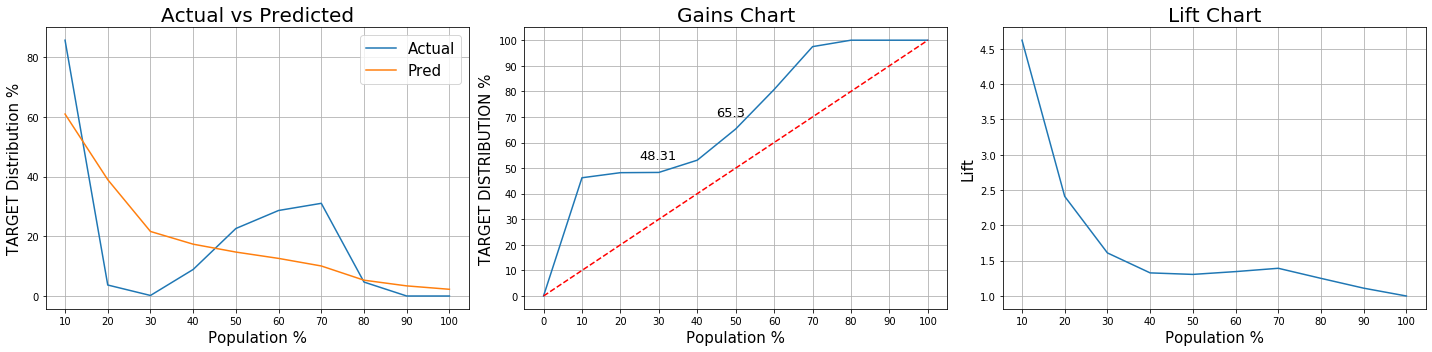

In [0]:
gains(lift_train,['DECILE'],'TARGET','SCORE')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: FutureWarning: `item` has been deprecated and will be removed in a future version
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: FutureWarning: `item` has been deprecated and will be removed in a future version
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: FutureWarning: `item` has been deprecated and will be removed in a future version
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: FutureWarning: `item` has been deprecated and will be removed in a future version


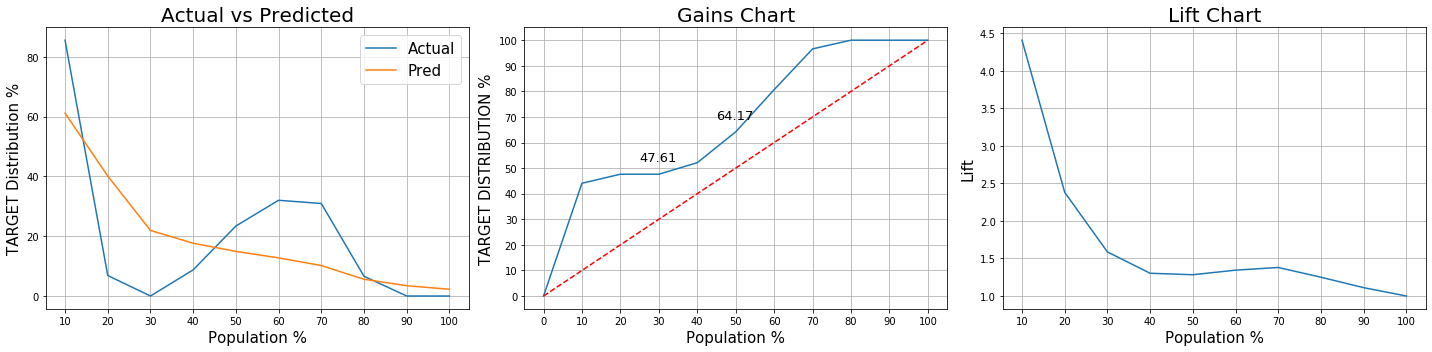

In [0]:
gains(lift_test,['DECILE'],'TARGET','SCORE')